# DAMASK tutorial

- creating necessary inputs for damask
- defining the elastoplastic model (with powerlaw) for tensile test
- runing the damask jobs

here more option is given to the user to select from damask python package itself.

## Importing libraries and creatign Project

In [1]:
from pyiron_continuum import Project
%matplotlib inline

### create a 'project' to manage all the configurations for a tensile test

In [2]:
pr = Project('RollingTest')
pr.remove_jobs(silently=True, recursive=True) # automatically delete the existing project folder

  0%|          | 0/2 [00:00<?, ?it/s]

### Creating the Damask job

In [3]:
job = pr.create.job.DAMASK("run_0")

#### for a damask job, one needs:
- geometry information(i.e., the mesh)
- material configuration(material.yaml)
- boundary conditions(i.e., loading.yaml)

### For material configuration
#### for elastoplastic material

In [4]:
elasticity = pr.continuum.damask.Elasticity(type= 'Hooke', C_11= 106.75e9,
                                   C_12= 60.41e9, C_44=28.34e9)
plasticity = pr.continuum.damask.Plasticity(type='phenopowerlaw',
                                            N_sl=[12],a_sl=[2.25],
                                            atol_xi=1.0,dot_gamma_0_sl=[0.001],
                                            h_0_sl_sl=[75.0e6],
                                            h_sl_sl=[1, 1, 1.4, 1.4, 1.4, 1.4, 1.4],
                                            n_sl=[20],
                                            output=['xi_sl'],
                                            xi_0_sl=[31.0e6],
                                            xi_inf_sl=[63.0e6]
                                           )


#### for material configuration, you need
- phase
- roation
- homogenization

In [5]:
grains = 4
grids = 4

phase = pr.continuum.damask.Phase(composition='Aluminum', lattice= 'cF',
                         output_list=['F', 'P', 'F_e', 'F_p', 'L_p', 'O'],
                         elasticity=elasticity,plasticity=plasticity)
rotation = pr.continuum.damask.Rotation(shape=grains)

homogenization = pr.continuum.damask.Homogenization(method='SX', 
                                                     parameters={'N_constituents': 1,
                                                                 "mechanical": {"type": "pass"}})

# now you can define your material.yaml configuration
material = pr.continuum.damask.Material([rotation],['Aluminum'], phase, homogenization)

# now you can save your material to your job
job.material = material

/home/jovyan/dev/pyiron_continuum/pyiron_continuum/damask/damaskjob.py:178: UserWarning: Setting material via project creator is deprecated. Use job.set_material instead
  warnings.warn(


## For geometry information

In [6]:
grid = pr.continuum.damask.Grid.via_voronoi_tessellation(box_size=1.0e-5, spatial_discretization=grids, num_grains=grains)

# save the geometry information to your job
job.grid = grid 

/home/jovyan/dev/pyiron_continuum/pyiron_continuum/damask/damaskjob.py:226: UserWarning: Setting grid via project creator is deprecated. Use job.set_grid instead
  warnings.warn(


In [7]:
def get_dot_F(reduction_speed):
    return ["x", 0, 0, 0, 0, 0, 0, 0, -1.0 * reduction_speed]

def get_load_step(reduction_speed, reduction_height, reduction_outputs):
    reduction_time = reduction_height / reduction_speed
    P = [0, "x", "x", "x", "x", "x", "x", "x", "x"]
    return {
        "mech_bc_dict": {"P": P, "dot_F": get_dot_F(reduction_speed)},
        "discretization": {"t": reduction_time, "N": reduction_outputs},
        "additional": {"f_out": 5, "f_restart": 5},
    }

# Define the 1st rolling test

In [8]:
reduction_height = 0.05
reduction_speed = 5.0e-2
reduction_outputs = 250

job.set_loading(solver=job.list_solvers()[0], load_steps=get_load_step(reduction_speed, reduction_height, reduction_outputs))
job.run()

The job run_0 was saved and received the ID: 7935


(0.0, 170000000.0)

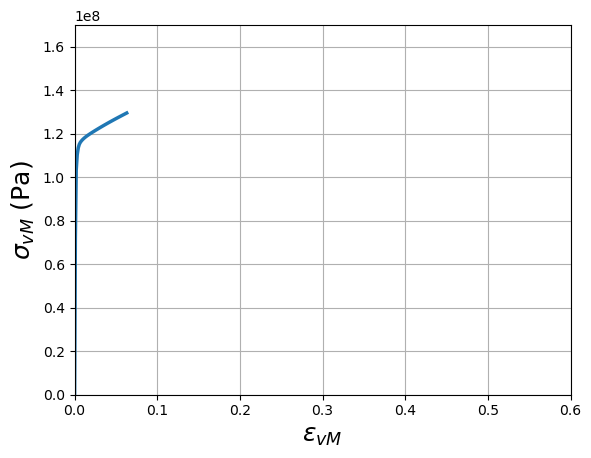

In [9]:
fig, ax = job.plot_stress_strain(von_mises=True)
ax.set_xlim([0.0, 0.60])
ax.set_ylim([0.0, 1.7e8])

# Now, we can do the 2nd rolling test, with different parameters

In [10]:
reduction_height = 0.1
reduction_speed = 4.5e-2
reduction_outputs = 300

job = job.restart(job_name="run_1")
job.append_loading(load_steps=get_load_step(reduction_speed, reduction_height, reduction_outputs))
job.input.regrid = True
job.run()

The job run_1 was saved and received the ID: 7936


(0.0, 170000000.0)

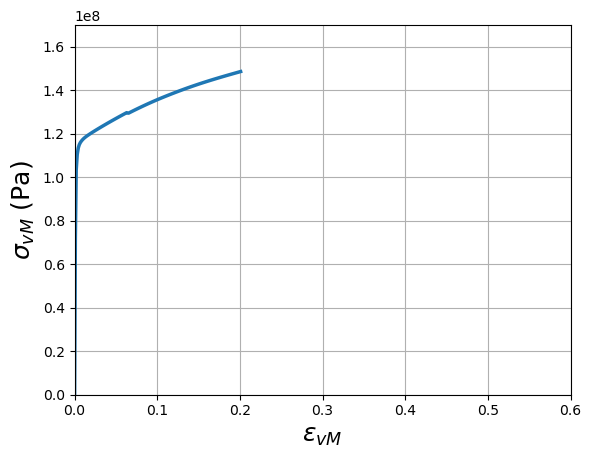

In [11]:
fig, ax = job.plot_stress_strain(von_mises=True)
ax.set_xlim([0.0, 0.60])
ax.set_ylim([0.0, 1.7e8])

# Now, we do the 3rd rolling test with finer mesh (regridding)

In [ ]:
reduction_height = 0.1
reduction_speed = 4.5e-2
reduction_outputs = 350
regrid_flag=True # enable the regridding

# execute the rolling test
job = job.restart(job_name="run_2")
job.append_loading(load_steps=get_load_step(reduction_speed, reduction_height, reduction_outputs))
job.input.regrid = True
job.run()

The job run_2 was saved and received the ID: 7937


In [ ]:
fig, ax = job.plot_stress_strain(von_mises=True)
ax.set_xlim([0.0, 0.60])
ax.set_ylim([0.0, 1.7e8])

# Now, we do the 4th rolling test with even finer mesh (regridding)

In [ ]:
reduction_height = 0.12
reduction_speed = 4.25e-2
reduction_outputs = 300
job = job.restart(job_name="run_3")
job.append_loading(load_steps=get_load_step(reduction_speed, reduction_height, reduction_outputs))
job.input.regrid = True
job.run()

In [ ]:
fig, ax = job.plot_stress_strain(von_mises=True)
ax.set_xlim([0.0, 0.60])
ax.set_ylim([0.0, 1.7e8])